## Multi-Model Inference

Take a DataFrame (from brtdevkit) and run inference on them using one or more models.</br>

* Fix Output classes for newer models
* Add a way to evaluate metrics for labeled images (Divya's old notebook)
* Hook up to aletheia / WanDB / Kubeflow? (Not Sure if Needed/Possible)
* 


In [1]:
from __future__ import print_function
import torch

import json
import time
from datetime import date, datetime

from pathlib import Path
import shutil
import os

import numpy as np
import pandas as pd

import requests
import itertools
from collections import OrderedDict

import skimage.transform as skt
import skimage

from random import sample
from scipy.special import softmax

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# brtdevkit
import brtdevkit
from brtdevkit.core.db import DBConnector
from brtdevkit.core.db.db_filters import *  # We need this for pre-defined filters, e.g., ProjectFilter, DatetimeFilter
import brtdevkit.util.s3 as brt_s3

# dl-core
import brtdl.metrics
from brtdl.metrics.evaluate_metrics import evaluate_metrics
from brtdl import inference, default_arguments
from brtdl.data import canonical_types, SampleKeys
from brtdl.data.dataset import PathDataset, PredictionDataset
from brtdl.data.loaders import im_reader, npy_reader
from brtdl.transforms import SegmentationTransform
from brtdl.visual import colorize_segmentation

from warnings import filterwarnings
filterwarnings("ignore")

/home/williamroberts/code/brtdevkit/venv/lib/python3.6/site-packages/brtdevkit/util/s3.py:9: DeprecationWarning: This import location will be removed in a future release. Import via brtdevkit.util.aws.s3
  DeprecationWarning
/home/williamroberts/code/brtdevkit/venv/lib/python3.6/site-packages/brtdl/metrics/metric_result.py:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  aggregate_series: pd.Series = pd.Series(), name: str = ''):


In [2]:
# Find the latest models on the 2021 Model Tracking Page: 
# https://bluerivertechnology.atlassian.net/wiki/spaces/SNS/pages/1865318625/2021+Model+Tracker

# Models need to have one output, not the image quality multi-headed outputs (dust, blur, etc)
# Can be a locally stored file or url
model_paths = {'20210317_1_corn_4':'/home/williamroberts/code/brtdevkit/Projects/Inference Images/models/20210317_1_corn_4.jit',
               '20210308_1_soybeans_4' : '/home/williamroberts/code/brtdevkit/Projects/Inference Images/models/20210308_1_soybeans_4.jit',
               '20210317_1_cotton_4':  '/home/williamroberts/code/brtdevkit/Projects/Inference Images/models/20210317_1_cotton_4.jit',
               '20210220_1_fallow_4' : '/home/williamroberts/code/brtdevkit/Projects/Inference Images/models/20210220_1_fallow_4.jit',
               '20210524_1_cotton_4' : '/home/williamroberts/code/brtdevkit/Projects/Inference Images/models/20210524_1_cotton_4.jit',
          '20200424_1_soybeans' : 'https://artifactory.bluerivertech.com/artifactory/dev-shasta-models/jit/20200424_1_soybeans/20200424_1_soybeans.jit',
          '20200506_1_soybeans':'https://artifactory.bluerivertech.com/artifactory/dev-shasta-models/jit/20200506_1_soybeans/20200506_1_soybeans.jit',
          '20200528_2_soybeans':'https://artifactory.bluerivertech.com/artifactory/dev-shasta-models/jit/20200528_2_soybeans/20200528_2_soybeans.jit',
          '20201101_1_soybeans_4': 'https://artifactory.bluerivertech.com:443/artifactory/dev-shasta-models/jit/20201101_1_soybeans_4/20201101_1_soybeans_4.jit',
          'allSoy_0': '/home/williamroberts/code/brtdevkit/Projects/Inference Images/models/allSoy_0.jit',
          'multi_head_output': 'https://artifactory.bluerivertech.com/artifactory/dev-shasta-models/jit/20201104_1_soybeans_5/20201104_1_soybeans_5.jit',
          '20210119_1_soybeans_4':'https://artifactory.bluerivertech.com/artifactory/dev-shasta-models/jit/20210119_1_soybeans_4/20210119_1_soybeans_4.jit',
          'current_cotton_model' : '/home/williamroberts/code/brtdevkit/Projects/Inference Images/models/current_cotton_model.jit',
          '20200528_1_soybeans': 'https://artifactory.bluerivertech.com/artifactory/dev-shashta-models-local/jit/20200528_1_soybeans/20200528_1_soybeans.jit'
}


In [3]:
# Functions to download inputs and run inference

def download_images(df, artifact_kind, outputdir):
    """
    Helper function to download images from S3 given a dataframe.
    :param df: dataframe, expected to be created by a query to brtdevkit
    :param artifact_kind: string
    :param outputdir: output directory to store the downloaded images
    """
    s3_client = brt_s3.S3()
    #print(f'Downloading {len(df)} source images...')
    for ix, row in df.iterrows():
        art = [x for x in row.artifacts if x['kind'] == artifact_kind]
        if art:
            art = art[0]
            fname = os.path.join(outputdir, os.path.basename(art['s3_key']))
            s3_client.download_file(art['s3_bucket'], art['s3_key'], fname)
    print('Source image download complete')
    
def download_from_url(url, fname):
    """
    Helper function to download data given an URL
    :param url: string, url of the file to be downloaded
    :param fname: filename of the downloaded file
    """
    r = requests.get(url, allow_redirects=False)
    with open(fname, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=128):
            fd.write(chunk)

def get_id_from_s3(df, key):
    """
    Helper function to retrieve an image id given a s3 key.
    """
    found = False
    for ix, row in df.iterrows():
        art = [x for x in row.artifacts if x['kind'] == 'nrg']
        if art:
            art = art[0]
            print(art['s3_key'][19:])
            if art['s3_key'][19:] == key:
                print(row['_id']) 
                found = True
    if found == False:
        print('Key not found')
        
def match_image_ids_to_s3(df):
    """
    Helper function to retrieve many image ids given a df with s3 keys.
    """
    s3 = []
    ids = []
    for ix, row in df.iterrows():
        s3.append(str(row.artifacts[0]['s3_key'][12:48]))
        ids.append(row['_id'])
        
    key_df = pd.DataFrame({'_id': ids, 's3_key':s3})
    return key_df

def generate_microscope_csv(field_directory, df):
    """
    Given a directory with nrg images and predictions for one field generate a csv for use in Microscope.
    :param: field_directory: a directory containing the different folders with nrg images and predictions
    :param: df: a dataframe with metadata for the imagesin the field directory
    """
    base_path = '/home/williamroberts/code/brtdevkit/Projects/Inference Images/'
    pred_dir = ''
    
    for d in os.listdir(field_directory):
        if d.endswith('predictions'):
            pred_dir = d

    key_df = match_image_ids_to_s3(df)
    
    # Create list of nrg images, s3_keys and _ids
    images = os.listdir(base_path + field_directory +'/nrg_images')
    s3_keys = [i[0:36] for i in images]
    
    image_ids = []
    for s3_key in s3_keys:
        image_ids.append(str(key_df[key_df['s3_key']==s3_key]['_id'].values[0]))
        
    # Create list of predictions and paths   
    pred_paths = [base_path + field_directory +'/' + pred_dir +'/' + s + '.jpg' for s in s3_keys]
    image_paths = [base_path + field_directory +'/nrg_images/' + i for i in images]
    
    # Create dataframe and csv
    for_micro = pd.DataFrame({'id': image_ids, 'artifact_nrg_0_save_path':image_paths, 'prediction_path': pred_paths})
    
    for_micro.to_csv(base_path + field_directory + '/micro.csv', index=False)
            
def run_inference_local(img_dir, model_path, result_dir, predictions_dir):
    """
    Use this function if the images and model are already downloaded and locally available.
    Inputs: 
    img_dir: a directory with png images (should be NRG888) to analyze
    model_path: the locally stored model you want to use
    result_dir: a directory to store the finished result images. Does not need to exist already.
    """
        
    if os.path.exists(result_dir)==False:
        os.mkdir(result_dir)
    if os.path.exists(predictions_dir)==False:
        os.mkdir(predictions_dir)
    
    channel_order = 'HWC'
    batch_size = 1
        
    resize_shape = (540, 960)#(model_metadata['input_shape'][2], model_metadata['input_shape'][3])
    with inference.managed_indir(default_arguments.PathTypes.abspath(img_dir)) as data_dir:
        suffix = inference.infer_suffix(data_dir, '')
        dset = inference.dset_dispatcher[suffix](data_dir, suffix, resize_shape, channel_order)

    # Run inference on downloaded images
    pred_gen = inference.predict_jit(dset, default_arguments.PathTypes.abspath(model_path), batch_size, device='cpu')

    try:
        for img_id, f_hat in pred_gen:
            y_hat = np.argmax(f_hat, axis=0).astype(np.ubyte)
            img = mpimg.imread(os.path.join(img_dir, img_id + suffix)) * 255.0
            img = img.astype(np.uint8)
            h, w, c = img.shape
            resized_yhat = skimage.transform.resize(y_hat, (h, w), order=0,
                                                    mode="constant", anti_aliasing=False, 
                                                    preserve_range=True)
            resized_yhat = resized_yhat.astype(np.uint8)
            colorized_img = colorize_segmentation(img, resized_yhat)
            out_path = os.path.join(result_dir, img_id[:36] + ".jpg")
            out_path_2 = os.path.join(predictions_dir, img_id[:36] + ".jpg")
            skimage.io.imsave(out_path, colorized_img)
            skimage.io.imsave(out_path_2, resized_yhat)
    except:
        for img_id, f_hat, heads in pred_gen:
            y_hat = np.argmax(f_hat, axis=0).astype(np.ubyte)
            img = mpimg.imread(os.path.join(img_dir, img_id + suffix)) * 255.0
            img = img.astype(np.uint8)
            h, w, c = img.shape
            resized_yhat = skimage.transform.resize(y_hat, (h, w), order=0,
                                                    mode="constant", anti_aliasing=False, 
                                                    preserve_range=True)
            resized_yhat = resized_yhat.astype(np.uint8)
            colorized_img = colorize_segmentation(img, resized_yhat)
            out_path = os.path.join(result_dir, img_id[:36] + ".jpg")
            out_path_2 = os.path.join(predictions_dir, img_id[:36] + ".jpg")
            skimage.io.imsave(out_path, colorized_img)
            skimage.io.imsave(out_path_2, resized_yhat)
        
def return_prediction(img_dir, model_path):
    """
    Use this function to run inference and return just the prediciton for a comparison.
    Inputs: 
    img_dir: a directory with png images (should be NRG888) to analyze
    model_path: the location of the model you want to use
    """
    
    channel_order = 'HWC'
    batch_size = 1
        
    resize_shape = (540, 960)#(model_metadata['input_shape'][2], model_metadata['input_shape'][3])
    with inference.managed_indir(default_arguments.PathTypes.abspath(img_dir)) as data_dir:
        suffix = inference.infer_suffix(data_dir, '')
        dset = inference.dset_dispatcher[suffix](data_dir, suffix, resize_shape, channel_order)

    # Run inference on downloaded images
    pred_gen = inference.predict_jit(dset, default_arguments.PathTypes.abspath(model_path), batch_size, device='cpu')
    for img_id, f_hat in pred_gen:
        y_hat = np.argmax(f_hat, axis=0).astype(np.ubyte)
        img = mpimg.imread(os.path.join(img_dir, img_id + suffix)) * 255.0
        img = img.astype(np.uint8)
        h, w, c = img.shape
        resized_yhat = skimage.transform.resize(y_hat, (h, w), order=0,
                                                mode="constant", anti_aliasing=False, 
                                                preserve_range=True)
        resized_yhat = resized_yhat.astype(np.uint8)
        return resized_yhat
        
def run_inference_from_web(image_initial, model_names, show_model_metadata=False):
    """
    Inputs: 
    image_initial: a pandas Dataframe queried from brtdevkit (where you can access the image s3 keys)
    model_names: a list containing model names from the soy_models dictionary

    Outputs, contained in separate directories:
    Downloaded NRG Images
    Model downloaded from local file or artifactory url
    Results images generated for each model
    """
    
    # Throw an error if the input DF is empty
    assert len(image_initial) > 0, 'Input DataFrame is empty. Nothing to analyze.'
    
    # Throw an error if more than one crop is represented in the DataFrame
    assert len(image_initial.crop_name.unique())==1, 'Multiple crop_names in DataFrame'
    
    today = date.today()
    out_name = f'{analysis_name}_{str(today).replace("-", "_")}'
    # '/home/williamroberts/code/brtdevkit/Projects/Inference Images/0528/CiaramaFazendas_4_SOYBEANS/nrgimages'
    out_dir = Path('') / Path(out_name)
    if os.path.exists(out_dir):
        shutil.rmtree(out_dir)
    out_dir.mkdir(parents=False, exist_ok=True)
    # Create directories for base images to analyze
    img_dir = Path('') / Path(out_name) / Path('nrg_images')
    img_dir.mkdir(parents=False, exist_ok=True)
    
    # Download Images To Infer
    download_images(image_initial, 'nrg', img_dir)
    
    for m in model_names:
        model_url = soy_models[m]
        model_name = os.path.basename(model_url)
        # Create out_dir and model_dir
        model_dir = out_dir 
        model_dir.mkdir(parents=False, exist_ok=True)
        result_dir = model_dir / Path(m+'_result_images')
        result_dir.mkdir(parents=False, exist_ok=True)
        
        if show_model_metadata:
            model_name = os.path.basename(model_url)
            metadata_name = 'metadata.json'
            metadata_url = os.path.join(os.path.dirname(model_url), 'metadata.json')
            metadata_path = model_dir / Path(metadata_name)
            download_from_url(metadata_url, metadata_path)
            with open(metadata_path, 'r') as f:
                model_metadata = json.load(f)
                print(m+' metadata.json:')
                print(model_metadata)
                print(' ')

        # TODO: Will need to change this to be available for multple crop_names, not just soy
        # Download model
        model_path = model_dir / Path(m + '.jit')
        if model_url[0:4] =='http':
            download_from_url(model_url, model_path)
        else:
            model_path = soy_models[m]
        run_inference_local(img_dir, model_path, result_dir)
        print(f'Inference completed for {m}')

def softmax_inference_local(img_dir, model_path, result_dir, threshold):
    """
    Use this function if the images and model are already downloaded and locally available.
    Inputs: 
    img_dir: a directory with png images (should be NRG888) to analyze
    model_path: the location of the model you want to use
    result_dir: a directory to store the finished result images. Does not need to exist already.
    
    TESTED: Works great!
    """
        
    if os.path.exists(result_dir)==False:
        os.mkdir(result_dir)
    
    channel_order = 'HWC'
    batch_size = 1
        
    resize_shape = (540, 960)#(model_metadata['input_shape'][2], model_metadata['input_shape'][3])
    with inference.managed_indir(default_arguments.PathTypes.abspath(img_dir)) as data_dir:
        suffix = inference.infer_suffix(data_dir, '')
        dset = inference.dset_dispatcher[suffix](data_dir, suffix, resize_shape, channel_order)

    # Run inference on downloaded images
    pred_gen = inference.predict_jit(dset, default_arguments.PathTypes.abspath(model_path), batch_size, device='cpu')
    for img_id, f_hat, heads in pred_gen:
        x = softmax(f_hat, axis=0)
        y_hat = np.greater(x[2, :, :], x[0, :, :]) * 2
        y_hat[x[1, :, :] > threshold] = 1
        y_hat = y_hat.astype(np.ubyte)
        img = mpimg.imread(os.path.join(img_dir, img_id + suffix)) * 255.0
        img = img.astype(np.uint8)
        h, w, c = img.shape
        resized_yhat = skimage.transform.resize(y_hat, (h, w), order=0,
                                                mode="constant", anti_aliasing=False, 
                                                preserve_range=True)
        resized_yhat = resized_yhat.astype(np.uint8)
        colorized_img = colorize_segmentation(img, resized_yhat)
        out_path = os.path.join(result_dir, img_id + ".jpg")
        skimage.io.imsave(out_path, colorized_img)

In [16]:
lm = pd.DataFrame({'grower':['Kuebler'], 'farm': ['Kuebler'],'operating_field_name': ['L164']})
lm

,grower,farm,operating_field_name
0,Kuebler,Kuebler,L164


In [17]:
def get_specific_fields(df, artifact = 'nrg'):
    """
    Takes a dataframe with specific [grower, farm, operating_field_name] combinations and retreives document records from 
    Aletheia matching just those fields. Useful when you  need a collection of fields but don't want to query the entire record.
    :param: df: a pandas dataframe with [grower, farm, operating_field_name] columns.
    :param: artifact: The type of artifact you want to return. Default is 'nrg'
     """
    db = DBConnector()
    filters = {'grower': df['grower'][0], 'farm': df['farm'][0],'operating_field_name': df['operating_field_name'][0]}
    img_filters = {'project_name': 'shasta', **filters, 'artifacts.kind':artifact}
    master_df = db.get_documents_df('image', img_filters, limit=None)
    for n in range(len(df[1:])):
        filters = {'grower': str(df['grower'][n]), 'farm': str(df['farm'][n]),'operating_field_name': str(df['operating_field_name'][n])}
        img_filters = {'project_name': 'shasta', **filters, 'artifacts.kind':artifact}
        field_df = db.get_documents_df('image', img_filters, limit=None)
        if len(field_df)==0:
            print(f'Could not find field: { df.operating_field_name[n]} from grower: {df.grower[n]}')
        master_df = pd.concat([master_df, field_df], axis=0)
    print(f'Query returned {len(master_df)} {artifact} records.')
    return master_df

#os.chdir('/home/williamroberts/code/brtdevkit/Projects/Inference Images/')
#field_eval = pd.read_csv('fields_to_evaluate.csv')


full_df = get_specific_fields(lm)
full_df['grower_farm_field'] = full_df['grower'] +'_' + full_df['farm'] + '_' + full_df['operating_field_name']
full_df.head()

Query returned 1388 nrg records.


,_id,is_deleted,created_at,updated_at,collected_on,gnss,annotations,artifacts,has_human_annotation,uuid,...,source,tillage_practice,type,weed_pressure,weeds,processing_type,geo_state,notes,collection_name,grower_farm_field
_id,,,,,,,,,,,,,,,,,,,,,
60be76deabc2a1e798a5f4c7,60be76deabc2a1e798a5f4c7,False,2021-06-07 19:40:54.233,2021-06-07 19:43:26.261,2021-04-21 16:10:28.787,"{'coordinates': [11.749077796936035, 51.421096...",[],"[{'_id': 60be76deabc2a1e798a5f4c5, 'kind': 'ra...",False,9e8ca2c8-8e9c-4f4b-881a-cfcf5f6de687,...,full_logs,CONVENTIONAL,nrg,MEDIUM,"[BLACK_GRASS, CAMOMILLA, CLEAVER, COMMON_AMARA...",ISP,Saxony-Anhalt,NaN,image,Kuebler_Kuebler_L164
60be7ab6a036660ac364056a,60be7ab6a036660ac364056a,False,2021-06-07 19:49:26.367,2021-06-07 19:59:50.358,2021-04-21 16:10:29.287,"{'coordinates': [11.74908447265625, 51.4211006...",[],"[{'_id': 60be7ab6a036660ac3640568, 'kind': 'ra...",False,47d01e3d-e218-43b6-9970-332b6a676c9d,...,full_logs,CONVENTIONAL,nrg,MEDIUM,"[BLACK_GRASS, CAMOMILLA, CLEAVER, COMMON_AMARA...",ISP,Saxony-Anhalt,NaN,image,Kuebler_Kuebler_L164
60be7b8d3732678d91e88fac,60be7b8d3732678d91e88fac,False,2021-06-07 19:50:31.832,2021-06-07 20:03:25.876,2021-04-21 16:10:29.787,"{'coordinates': [11.749091148376465, 51.421104...",[],"[{'_id': 60be7b8d3732678d91e88faa, 'kind': 'ra...",False,1bc3af0e-80d8-4c32-8188-ff92af96980b,...,full_logs,CONVENTIONAL,nrg,MEDIUM,"[BLACK_GRASS, CAMOMILLA, CLEAVER, COMMON_AMARA...",ISP,Saxony-Anhalt,NaN,image,Kuebler_Kuebler_L164
60be775f0c5b4e56d8c3c0dd,60be775f0c5b4e56d8c3c0dd,False,2021-06-07 19:41:52.841,2021-06-07 19:45:35.390,2021-04-21 16:10:30.287,"{'coordinates': [11.749098777770996, 51.421108...",[],"[{'_id': 60be775f0c5b4e56d8c3c0db, 'kind': 'ra...",False,3b3712e3-73ef-4e28-9801-883d828e304a,...,full_logs,CONVENTIONAL,nrg,MEDIUM,"[BLACK_GRASS, CAMOMILLA, CLEAVER, COMMON_AMARA...",ISP,Saxony-Anhalt,NaN,image,Kuebler_Kuebler_L164
60be775e947e2090e1082454,60be775e947e2090e1082454,False,2021-06-07 19:42:55.911,2021-06-07 19:45:34.488,2021-04-21 16:10:30.787,"{'coordinates': [11.749107360839844, 51.421112...",[],"[{'_id': 60be775e947e2090e1082452, 'kind': 'ra...",False,5bdf94fb-786b-4e43-9bc8-5e6c25101650,...,full_logs,CONVENTIONAL,nrg,MEDIUM,"[BLACK_GRASS, CAMOMILLA, CLEAVER, COMMON_AMARA...",ISP,Saxony-Anhalt,NaN,image,Kuebler_Kuebler_L164


In [4]:
# Query dataframe fields to evaluate

def get_shasta_data(filters={}, start=None, end=None, limit=None):
    """
    Query relevant Shasta data for calculations. 
    """
    start_time = time.time()
    connector = DBConnector()
    img_filters = {'project_name': 'shasta', **filters}
    if start is not None or end is not None:
        img_filters = [img_filters, DatetimeFilter(key="collected_on", start=start, end=end)]
    df = connector.get_documents_df('image', img_filters, limit=limit)
    elapsed_time = time.time() - start_time
    return df, elapsed_time

# Set start and end dates for query
start = datetime(2021, 4, 1)
end = datetime(2021, 7,5)

# Lists of DCMs and Machines
dcms = ['DCM-MANATEE', 'DCM-WALRUS', 'DCM-SEAL', 'DCM-OTTER', 'DCM-PORPOISE', 'DCM-DOLPHIN']
dcms_2021 = ['DCM11', 'DCM12', 'DCM13', 'DCM14','DCM16', 'DCM18', 'DCM19', 'DCM20', 'DCM21','DCM22','DCM23','DCM24','DCM25', 'DCM26', 'DCM27']
db_usl = ['db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9']

machines = ["SHASTA-FB-BRADLEY","SHASTA-FB-PALADIN", "BLACKBIRD", 'ATM-DUCKDUCK', 'ATM-GOOSE']
valid_isp_versions = ['07080203','07090000','07090100']

# Select filters
filters = { "artifacts.kind": "nrg",  
           'robot_name' : {'$in': db_usl},
           'crop_name':
           
          }

full_df, elapsed_time = get_shasta_data(filters=filters, start = start, end = end)
full_df['date_collected'] = pd.to_datetime(full_df['collected_on']).dt.date
full_df['grower_farm_field'] = full_df['grower'] +'_' + full_df['farm'] + '_' + full_df['operating_field_name']
print(f"Queried {len(full_df)} images in {elapsed_time:.2f} s.")

Queried 726651 images in 251.91 s.


In [6]:
full_df.date_collected.unique()

array([datetime.date(2021, 4, 20), datetime.date(2021, 4, 21),
       datetime.date(2021, 4, 22), datetime.date(2021, 4, 23),
       datetime.date(2021, 4, 26), datetime.date(2021, 4, 27),
       datetime.date(2021, 4, 28), datetime.date(2021, 5, 4),
       datetime.date(2021, 5, 17), datetime.date(2021, 5, 18),
       datetime.date(2021, 5, 19), datetime.date(2021, 5, 20),
       datetime.date(2021, 5, 21), datetime.date(2021, 5, 22),
       datetime.date(2021, 5, 24), datetime.date(2021, 5, 25),
       datetime.date(2021, 5, 26), datetime.date(2021, 5, 27),
       datetime.date(2021, 5, 28), datetime.date(2021, 5, 29),
       datetime.date(2021, 5, 31), datetime.date(2021, 6, 1),
       datetime.date(2021, 6, 2), datetime.date(2021, 6, 3),
       datetime.date(2021, 6, 4), datetime.date(2021, 6, 7),
       datetime.date(2021, 6, 8), datetime.date(2021, 6, 9),
       datetime.date(2021, 6, 10), datetime.date(2021, 6, 13),
       datetime.date(2021, 6, 14), datetime.date(2021, 6, 15),


In [13]:
select_df = full_df[(full_df['robot_name']=='db2') & (full_df['date_collected']==datetime(2021, 6, 25).date())]
select_df.grower_farm_field.unique()

array([nan], dtype=object)

In [15]:
evaled = pd.read_csv('field_eval.csv')
evaled['grower_farm_field'] = evaled['grower'] +'_' + evaled['farm'] + '_' + evaled['operating_field_name']

len(full_df[~full_df['grower_farm_field'].isin(evaled['grower_farm_field'].unique())].grower_farm_field.unique())

85

In [27]:
def match_image_ids_to_s3(df):
    """
    Helper function to retrieve many image ids given a df with s3 keys.
    """
    s3 = []
    ids = []
    for ix, row in df.iterrows():
        for i in range(len(row.artifacts)):

            if row.artifacts[i]['kind'] == 'nrg':
                s3.append(str(row.artifacts[i]['s3_key'][12:48]))#
                ids.append(row['_id'])
        
    key_df = pd.DataFrame({'_id': ids, 's3_key':s3})
    return key_df

key_df = match_image_ids_to_s3(full_df[0:5])
key_df.s3_key[4]

'85e3d670-5672-4690-bb2e-cd11db827ffa'

In [28]:
key_df = match_image_ids_to_s3(full_df)

def generate_microscope_csv(field_directory, df):
    """
    Given a directory with nrg images and predictions for one field generate a csv for use in Microscope.
    :param: field_directory: a directory containing the different folders with nrg images and predictions
    :param: df: a dataframe with metadata for the imagesin the field directory
    """
    # I need to figure outhow I don't need to change this every time
    
    base_path = '/home/williamroberts/code/brtdevkit/Projects/Inference Images/'
    pred_dir = ''
    
    for d in os.listdir(base_path + field_directory):
        if d.endswith('predictions'):
            pred_dir = d
    
    # Create list of nrg images, s3_keys and _ids
    images = os.listdir(base_path + field_directory +'/nrg_images')
    s3_keys = [i[0:36] for i in images]

    image_ids = []
    for s3_key in s3_keys:
        image_ids.append(str(key_df[key_df['s3_key']==s3_key]['_id'].values[0]))
        
    # Create list of predictions and paths   
    pred_paths = [base_path + field_directory +'/' + pred_dir +'/' + s + '.jpg' for s in s3_keys]
    image_paths = [base_path + field_directory +'/nrg_images/' + i for i in images]
    
    # Create dataframe and csv
    for_micro = pd.DataFrame({'id': image_ids, 'artifact_nrg_0_save_path':image_paths, 'prediction_path': pred_paths})
    
    for_micro.to_csv(base_path + field_directory + '/micro.csv', index=False)


In [29]:
key_df.head()

,_id,s3_key
0,5f7f4dfb6850c223b63c5c50,cbf7b495-f548-4f82-a1da-b21853d53cbd
1,5f74643b9c95eead88768c1f,161ef22f-4de6-4542-9462-4b929b751371
2,5f1088640e521843c6382cc5,/02/20/1db30c3e1ee6464bbb2191675a3c3
3,5faeaa2e1f6fbb2ed030c5de,99707e31-0806-4ebc-867a-78413e89677e
4,5f8eaca300262540382b24e4,85e3d670-5672-4690-bb2e-cd11db827ffa


In [18]:
# Choose a name for your analysis
analysis_name = 'BeetRed2'
today = date.today()
analysis_name = f'{analysis_name}_{str(today).replace("-", "_")}'
print('Results will be stored in:', analysis_name)

# models to use in inference
corn_model = '20210317_1_corn_4'
soy_model = '20210308_1_soybeans_4'
cotton_model = '20210524_1_cotton_4'
fallow_model = '20210220_1_fallow_4'

base_dir = '/home/williamroberts/code/brtdevkit/Projects/Inference Images/'

Results will be stored in: BeetRed2_2021_07_11


In [84]:
# Create a list of fields to run inference on

probably_flag = ['dunn farms_lakeside_turnrow', 'dunn farms_lakeside_some plants',
       'dunn farms_lakeside_crop with weeds']

problematic_fields_still_need_to_analyze = ['Andew Miller_Andrew Miller Farms_Sandridge 3700-J/0370010',
                     'Andrew Miller_Andrew Miller Farms_Steele East 3567/Steele 1', "james whitaker_whitaker farms_behind shp/naomi's",
       'jeremy jack_silent shade_silver creek plantat/22',"neil lee_lee farms_beside neil's"]


In [19]:
# Function to run inference on many fields at once

def generate_evaluations(fields, df, n_images = 50):
    """
    Model names and analysis name should be set up in the previous cell.
    Input is list of grower_farm_field names to run inference on and store results
    """
    # assign models by crop
    for f in fields:
        field_df = df[df['grower_farm_field']==f]
        if field_df.crop_name.unique()[0] == 'CORN':
            model = corn_model 
        elif field_df.crop_name.unique()[0] == 'WHEAT':
            model = corn_model 
        elif field_df.crop_name.unique()[0] == 'SUGARBEETS':
            model = soy_model
        elif field_df.crop_name.unique()[0] == 'SOYBEANS':
            model = soy_model
        elif field_df.crop_name.unique()[0] == 'COTTON':
            model = cotton_model
        elif field_df.crop_name.unique()[0] == 'NONE_FALLOW_PRE_EMERGE':
            model = fallow_model
        elif field_df.crop_name.unique()[0] == 'OTHER':
            model = soy_model
        else:
            print(f'Unrecognized crop in {f}')
            break
            
        base_dir = '/home/williamroberts/code/brtdevkit/Projects/Inference Images/'
        
        # Create directories for analysis, images
        if os.path.exists(base_dir + analysis_name)==False:
            os.mkdir(base_dir + analysis_name)
        
        analysis_dir = base_dir + analysis_name + '/' + str(f)
        nrg_dir = analysis_dir + '/nrg_images'
        
        if os.path.exists(analysis_dir)==False:
            os.mkdir(analysis_dir)
        if os.path.exists(nrg_dir)==False:
            os.mkdir(nrg_dir)
        elif os.path.exists(nrg_dir)==True:
            shutil.rmtree(nrg_dir)
            os.mkdir(nrg_dir)

        model_path = model_paths[model]
        
        # Choose images and download
        image_sample = sample(field_df._id.to_list(), n_images)
        sparse = field_df[field_df['_id'].isin(image_sample)]
        download_images(sparse, 'nrg', nrg_dir)

        # create directory for results
        results_dir = analysis_dir + '/' + str(model) + '_results'
        predictions_dir = analysis_dir + '/' + str(model) + '_predictions'

        # Save results in the result dir
        run_inference_local(nrg_dir, model_path, results_dir, predictions_dir)
        
        #bit of code to delete extra images - needs a real fix
        imgs = os.listdir(nrg_dir)
        preds = os.listdir(predictions_dir)
        
        for i in imgs:
            if str(i[0:36])+'.jpg' in preds:
                continue
            else:
                try:
                    os.remove(analysis_dir + '/nrg_images/' + i)
                    print('Deleted 1 images')
                except:
                    print(f'could not delete {analysis_dir}/nrg_images/{i}')
                    continue

generate_evaluations(fields=full_df.grower_farm_field.unique(), df =full_df, n_images = 51)

Source image download complete


In [21]:
# Function to run inference on many fields at once

def usl_evaluation(df, n_images = 50):
    """
    Model names and analysis name should be set up in the previous cell.
    Input is list of grower_farm_field names to run inference on and store results
    """
    # assign models by crop
    model = select_df.active_model.unique()[0]
            
    base_dir = '/home/williamroberts/code/brtdevkit/Projects/Inference Images/'
        
        # Create directories for analysis, images
    if os.path.exists(base_dir + analysis_name)==False:
        os.mkdir(base_dir + analysis_name)
        
    analysis_dir = base_dir + analysis_name + '/' + df.robot_name.unique()[0] + str(df.date_collected.unique()[0])
    nrg_dir = analysis_dir + '/nrg_images'
        
    if os.path.exists(analysis_dir)==False:
        os.mkdir(analysis_dir)
    if os.path.exists(nrg_dir)==False:
        os.mkdir(nrg_dir)
    elif os.path.exists(nrg_dir)==True:
        shutil.rmtree(nrg_dir)
        os.mkdir(nrg_dir)

    model_path = model_paths[model]
        
    # Choose images and download
    image_sample = sample(df._id.to_list(), n_images)
    sparse = df[df['_id'].isin(image_sample)]
    download_images(sparse, 'nrg', nrg_dir)

    # create directory for results
    results_dir = analysis_dir + '/' + str(model) + '_results'
    predictions_dir = analysis_dir + '/' + str(model) + '_predictions'

    # Save results in the result dir
    run_inference_local(nrg_dir, model_path, results_dir, predictions_dir)
        
    #bit of code to delete extra images - needs a real fix
    imgs = os.listdir(nrg_dir)
    preds = os.listdir(predictions_dir)
        
    for i in imgs:
        if str(i[0:36])+'.jpg' in preds:
            continue
        else:
            try:
                os.remove(analysis_dir + '/nrg_images/' + i)
                print('Deleted 1 images')
            except:
                print(f'could not delete {analysis_dir}/nrg_images/{i}')
                continue
                
usl_evaluation(select_df)

Source image download complete
Deleted 1 images


In [30]:
for m in os.listdir(str(analysis_name)):
    mr = generate_microscope_csv(field_directory = str(analysis_name) + '/'+m, df=full_df)
print('csvs all complete')

6e01cfd5-6245-4cce-8d2a-e48d883d6957
887461c9-b739-4d53-a8cc-c4027682b4ea
e526f51b-52d4-4101-a513-4dd4ca79e11f
4d20116c-dc20-47ce-b7f6-511dce8b6111
38c8dba8-3c26-433c-974d-bdbe36c9c2b9
e585f1ad-4886-45ea-9330-8e88d57935b9
cc41f93f-bcea-4512-a64a-f0667d6e96f7
48ea0bc5-1f25-4533-8ef9-08a784d5a26a
420ef93d-999b-4a04-b9a5-9ae2045a570f
c047afb0-08e4-4041-89af-e3bb6e81e837
3a7af2d0-5cf9-4993-b7cf-d08b326649c8
785b0e7e-64bf-4615-93ef-2703c36f48ec
d5688c44-f228-4178-aaf3-364cab6536ea
f2c0f549-638d-4839-b632-ba0beb7091dc
64dabb7d-afb5-4ed5-9e8f-dc9ef2adba9c
d9e50f74-f61c-43ef-81e1-8fdd782b10d6
4ed10a60-651a-4ac1-94e9-1d29a37ee637
ba43ad89-3c81-4e00-8e2f-b52116547d04
3ad665e1-d6b4-42f6-85a3-8f319c987c2d
f8ab265b-1cdf-46e0-9afc-8850b21efa87
fe10e611-9931-4a8e-a0a6-6f8390e6e7e1
b7f9caaf-165b-4c95-8a65-b8f4aa9dce05
982a0c66-54ef-444a-9f04-dc8244b72474
623095ed-7270-438e-9ba7-dd8da735fe81
f69b728e-fe10-4e5a-bbde-c36f9916e4be
b995dca7-2e7b-420a-b18d-b3bd1d76c595
c8799658-b5c5-4090-b68f-de5323234443
2

IndexError: index 0 is out of bounds for axis 0 with size 0

In [50]:
# Code for testing different sensitivity levels

img_dir = '/home/williamroberts/code/brtdevkit/Projects/Inference Images/April_Texas_Corn_2021_04_18/nrg_images/'
model_path = '/home/williamroberts/code/brtdevkit/Projects/Inference Images/models/20210317_1_corn_4.jit'

dirs = ['/home/williamroberts/code/brtdevkit/Projects/Inference Images/April_Texas_Corn_2021_04_18/corn_result_images0_4/',
        '/home/williamroberts/code/brtdevkit/Projects/Inference Images/April_Texas_Corn_2021_04_18/corn_result_images0_6/',
        '/home/williamroberts/code/brtdevkit/Projects/Inference Images/April_Texas_Corn_2021_04_18/corn_result_images0_7/'
       ]

thresholds = [0.4, 0.6, 0.8]

for d in range(len(dirs)):
    softmax_inference_local(img_dir, model_path, dirs[d], threshold = thresholds[d])

In [ ]:

full_df.operating_field_name.unique()

grower = 'Stutts'
crop_name = 'CORN'
operating_field_name = 'Dion Field'
limit = None # The number of images you want to return. If 'None', there is no limit

connector = DBConnector()
image_initial = connector.get_documents_df('image', [ProjectFilter('shasta'),
                                                ValueFilter('crop_name', crop_name),
                                                ValueFilter('grower', grower),
                                                ValueFilter('artifacts.kind', 'nrg'),
                                                ValueFilter('operating_field_name', operating_field_name)], limit=limit)
print(len(image_initial))
image_initial.experiment_id.unique()

In [30]:
# Compare results of three models
imd = '/home/williamroberts/code/brtdevkit/Projects/Inference Images/just_one/'
mod = '/home/williamroberts/code/brtdevkit/Projects/Inference Images/models/allSoy_0.jit'

mods = [ '/home/williamroberts/code/brtdevkit/Projects/Inference Images/models/allSoy_0.jit', 
        '/home/williamroberts/code/brtdevkit/Projects/Inference Images/models/20200528_2_soybeans.jit' ]

def return_prediction(img_dir, model_path):
    """
    Use this function to run inference and return just the prediciton for a comparison.
    Inputs: 
    img_dir: a directory with png images (should be NRG888) to analyze
    model_path: the location of the model you want to use
    """
    
    channel_order = 'HWC'
    batch_size = 1
        
    resize_shape = (540, 960)#(model_metadata['input_shape'][2], model_metadata['input_shape'][3])
    with inference.managed_indir(default_arguments.PathTypes.abspath(img_dir)) as data_dir:
        suffix = inference.infer_suffix(data_dir, '')
        dset = inference.dset_dispatcher[suffix](data_dir, suffix, resize_shape, channel_order)

    # Run inference on downloaded images
    pred_gen = inference.predict_jit(dset, default_arguments.PathTypes.abspath(model_path), batch_size, device='cpu')
    for img_id, f_hat in pred_gen:
        y_hat = np.argmax(f_hat, axis=0).astype(np.ubyte)
        img = mpimg.imread(os.path.join(img_dir, img_id + suffix)) * 255.0
        img = img.astype(np.uint8)
        h, w, c = img.shape
        resized_yhat = skimage.transform.resize(y_hat, (h, w), order=0,
                                                mode="constant", anti_aliasing=False, 
                                                preserve_range=True)
        resized_yhat = resized_yhat.astype(np.uint8)
        return resized_yhat


In [46]:
model_1 = '/home/williamroberts/code/brtdevkit/Projects/Inference Images/models/allSoy_0.jit'
model_2 = '/home/williamroberts/code/brtdevkit/Projects/Inference Images/models/20200528_2_soybeans.jit'
model_3 = '/home/williamroberts/code/brtdevkit/Projects/Inference Images/models/20201020_2_soybeans_4.jit'

def generate_scores(image):
    """
    Generate model comparison scores for one image using three models
    """
    l1 = return_prediction(image, model_1)
    l2 = return_prediction(image, model_2)
    l3 = return_prediction(image, model_3)
    
    def jc(pred):
        return (np.shape(np.where(pred == pred_class))[1])
    diffs = []
    for n in [0,1,2]:
        pred_class=n
        diffs.append(int(abs(jc(l1) - np.mean([jc(l1), jc(l2), jc(l3)]))))
    return diffs
    

In [116]:
model_url = soy_models['multi_head_output']

model_name = os.path.basename(model_url)

metadata_name = 'metadata.json'
metadata_url = os.path.join(os.path.dirname(model_url), 'metadata.json')
metadata_path = model_dir / Path(metadata_name)
download_from_url(metadata_url, metadata_path)

with open(metadata_path, 'r') as f:
    model_metadata = json.load(f)
    
print(model_metadata)

{'rank': 1, 'creation_date': '20201104', 'model_type': 'semantic_segmentation_image_quality', 'model_architecture': 'TruncatedPyramid4xMultiLabels', 'crop_type': ['soybeans'], 'input_order': 'NCHW', 'input_shape': [5, 3, 540, 960], 'input_data_format': 'NRG', 'input_data_type': 'float32', 'input_data_range': 'rangenorm', 'output_shape': [[135, 240], [3]], 'output_data_format': {'0': 'soil', '1': 'weed', '2': 'crop'}, 'config_parameters': {'train_info_link': ''}, 'image_quality': {'default_threshold': [0.6, 0.5, 0.6], 'output_index_mapping': {'0': 'dust', '1': 'lowlight', '2': 'blur'}}, 'release_version': ['20201104', 1, 'soybeans', 5]}


In [1]:
def get_id_from_s3(df, key):
    """
    Helper function to retrieve an image id given a s3 key.
    """
    for ix, row in df.iterrows():
        art = [x for x in row.artifacts if x['kind'] == 'nrg']
        state = 0
        if art:
            art = art[0]
            #print(art['s3_key'][19:])
            if art['s3_key'][19:] == key:
                print(row['_id']) 

def get_s3_from_id(df, image_id):
    """
    Helper function to retreive a s3 key given an image id.
    """
    
    
get_id_from_s3(full_df, '1e8ea435d56d4d33ad4859807874d498_nrg.png')

NameError: name 'full_df' is not defined

In [4]:
datetime(2021, 3, 4)

datetime.datetime(2021, 3, 4, 0, 0)

In [18]:
def show_comparison(out_dir, index):
    results_dirs = []
    for f in os.listdir(out_dir):
        if f[-13:]== 'result_images':
            results_dirs.append(f)
    fig = plt.figure(figsize=(12, 12))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(len(results_dirs) // 2, 2),  # creates 2x2 grid of axes
                     axes_pad=0.2,  # pad between axes in inch.
                     )
    #img_list = os.listdir(out_name + '/' + dirs[0])
    ims = []
    for d in results_dirs:
        img_path_list = os.listdir(out_name + '/' + d)
        ims.append(out_name + '/' + d + '/' + img_path_list[index])
        for ax, im in zip(grid, ims):
        # Iterating over the grid returns the Axes.
            gm = plt.imread(im)
            ax.set_title((str(im).split(out_name+'/')[1]).split('_result_images')[0])

            ax.imshow(gm)
    print(ims[0][-40:-8])

c45e38a7b16140a7bfc757b50e398843


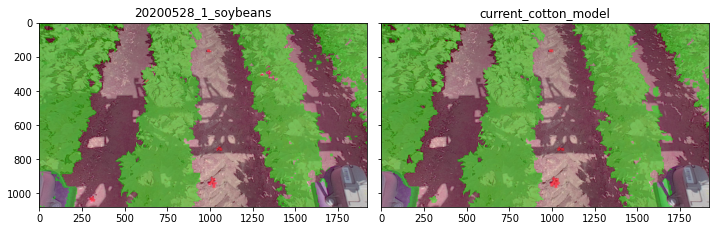

In [19]:
show_comparison(out_name, 0)

In [83]:
print(get_id_from_s3(df = image_initial, key = 'b21b5d82bc034102b0cab2b615f95e4d'))


None


In [113]:
show_comparison(out_name, 2)

IndexError: list index out of range

<Figure size 864x864 with 0 Axes>

In [ ]:
# Functions for generating metrics

# model_url = f'https://artifactory.bluerivertech.com/artifactory/dev-shasta-models/jit/{model_name}/{model_name}.jit'

def get_annotated_df(start, end, crop_name, ):
    db = DBConnector()

    img_filters = [{
        'project_name': 'shasta',
        "crop_name": crop_name,
        'artifacts': {"$elemMatch": {'s3_bucket': {"$exists": True}, 's3_key': {"$exists": True}}},
        "annotations": {"$elemMatch": {"is_active_version": True, "state": "ok", "kind": {"$nin": ["ndvi_mask", "machine"]}, "style": 'pixelwise', 's3_bucket': {"$exists": True}, 's3_key': {"$exists": True},  'label_map': {'$in': [{'1': 'crop', '2': 'weed'}, {'1': 'weed', '2': 'crop'}]}}},
    }, 
    DatetimeFilter(key='collected_on', start=start_date, end=end_date)
    ]
    df = db.get_documents_df('image', img_filters, limit=None)
    print("I have a dataframe of length: ", len(df))

def download_assets(directory, df):
    """
    Downloads s3 assets of a given list
    Args:
        directory (Path): the path that the assets will be saved to
        assets (iter(dict)): an iterable containing metadata objects that have s3 assets.
            Will usually be a dataframe column (ex: `image_df['artifacts'].explode()`)
    """
    s3_client = brt_s3.S3()

    def _download(asset, filepath):
        filepath.parent.mkdir(parents=True, exist_ok=True)
        return s3_client.download_file(asset['s3_bucket'], asset['s3_key'], str(filepath))

    for _, row in tqdm(df.iterrows(), total=df.shape[0]):
        datapoint_id = str(row['_id'])
        try:
            annotation = [a for a in row['annotations'] if a['is_active_version'] and a['kind'] != "ndvi_mask" and a['style'] == 'pixelwise'][0]
        except:
            annotation = [a for a in row['annotations'] if a['kind'] in ['f8', 'labelbox', 'brt', 'dataloop']][0]

        artifact = [a for a in row['artifacts'] if a['kind'] == 'nrg'][0]
        _download(artifact, directory / f'{datapoint_id}_nrg.png')
        _download(annotation, directory / f'{datapoint_id}_ann.png')

def create_dataset():
    """
    Set up your list of img ids and annotation ids. 
    """
    


    dp_ids = df_filtered.index.to_list()
    image_paths = [img_dir / f'{dp_id}_nrg.png' for dp_id in dp_ids]
    label_paths =  [img_dir / f'{dp_id}_ann.png' for dp_id in dp_ids]

    transforms = inference.dset_transform('.png', model_metadata['input_shape'][2:], model_metadata['input_order'])
    dset = PathDataset(image_paths=image_paths, label_paths=label_paths, img_ids=dp_ids, reader=im_reader, transform=SegmentationTransform(transforms))
    pred_gen = inference.predict_jit(dset, default_arguments.PathTypes.abspath(model_path), 1, 'cpu')
    
def fix_labelmaps():
    """
    
    """
                                 
def generate_and_aggregate_metrics():
    """
    
    """
    